In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
# Get the device
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [12]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

# # intialize a dataset
city = 'austin' 
split = 'train'

def normalize(trajectories):
    minxy = np.min(trajectories, axis=-1)
    maxxy = np.max(trajectories, axis=-1)
    scale = np.max(maxxy - minxy) / 2.0
    return (trajectories / scale), scale

def unnormalize(trajectories, scale):
    return trajectories * scale


def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
#         tensor = torch.Tensor(self.feature[item])
#         tensorlabel = torch.Tensor(self.label[item])
#         return tensor.to(device), tensorlabel.to(device)

        data = np.concatenate((self.inputs[idx], self.outputs[idx]))
            
        if self.transform:
            data = self.transform(data)

        return torch.Tensor(data).to(device)
    
# every path has length 110, with the 110nd character as target value
# set range step higher if overfit     
# if dataArr is with velocity, remove for y labels
def create_set(dataArr, normalization=False):
    normArr = dataArr
    scale = 0
    set_x = []
    set_y = []
    if(normalization):
        normArr, scale = normalize(dataArr)
    for path in normArr:
            set_x.append(path[:108])
            set_y.append(path[108])
    return set_x, set_y, scale

class mydataset(Dataset):
    def __init__(self, x, y):
        
        self.feature = x
        self.label = y
        
    def __getitem__(self, item):
        
        tensor = torch.Tensor(self.feature[item])
        tensorlabel = torch.Tensor(self.label[item])
        return tensor.to(device), tensorlabel.to(device)
    
    def __len__(self):
        return len(self.feature)
    
# input: n*110*2 paths
# output: n*110*4 paths with dim2 = [x,y,Vx,Vy], where Vx, Vy are velocity with length/.1s as unit
def addVelocity(dataArr):
    dataWV = []
    for path in np.array(dataArr):
        pathWV = []
        pathWV.append(np.concatenate((path[0], [0,0])))
        for coord in range(1, len(path)):
            vel = path[coord] - path[coord-1]
            coordWV = np.concatenate((path[coord], vel))
            pathWV.append(coordWV)
        dataWV.append(pathWV)
    return np.array(dataWV)

def calcVelocity(dataArr):
    dataWV = []
    for path in np.array(dataArr):
        pathWV = []
#         pathWV.append(path[1] - path[0])
        for coord in range(1, len(path)):
            vel = path[coord] - path[coord-1]
            pathWV.append(vel)
        dataWV.append(pathWV)
    return np.array(dataWV)

# shifts every path to be starting from 0,0
# returns shifted data Array, each array's shifted value
def toOrigin (dataArr):
    dataO = []
    shiftArr = []
    for path in np.array(dataArr):
        pathO = []
        shifter = path[0]
        shiftArr.append(shifter)
        for coord in range(len(path)):
            shifted = path[coord] - shifter
            pathO.append(shifted)
        dataO.append(pathO)
    return dataO, shiftArr

In [13]:

# get train data
inputs, outputs = get_city_trajectories(city=city, split=split, normalized=False)
all_in_1 = []
for i in range(len(inputs)):
    togetherData = np.concatenate((inputs[i], outputs[i]))
    all_in_1.append(togetherData)


# Get Validation Data
inputs, outputs = get_city_trajectories(city=city, split='val', normalized=False)
val_in_1 = []
for i in range(len(inputs)):
    togetherData = np.concatenate((inputs[i], outputs[i]))
    val_in_1.append(togetherData)
    
# random subsampling from val_set to make faster validation
numValPath = 300
val_index = np.random.choice(len(val_in_1), numValPath, replace=False)
val_in_1_500 = np.array(val_in_1)[val_index]


In [16]:
def prepDataSet(data):
    velArr = calcVelocity(data)
    set_x, set_y, scale = create_set(velArr)
    processedDataSet = mydataset(set_x, set_y)
    return processedDataSet

In [17]:
train_set = prepDataSet(all_in_1)
val_set = prepDataSet(val_in_1_500)

Data Processing Done (shift to origin -> unify starting direction -> add velocity -> return proessedDataSet, convBackArr)

# DataLoader

In [80]:
batch_sz = 64  # batch size 
train_loader = DataLoader(train_set,batch_size=batch_sz, shuffle = True)
val_loader = DataLoader(val_set, batch_size=batch_sz, shuffle = True)

# LSTM Model Implementation

In [244]:
from torch import nn, optim

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        #Hidden dimensions
        self.hidden_dim = hidden_dim
        
        #Number of hidden layers
        self.layer_dim = layer_dim
        
        #imput dim
        self.input_dim = input_dim
        
#         inFc2 = int(hidden_dim)/2
        
        
        #Building your LSTM
        #batch_first=True causes input/output tensors to be of shape
        #(batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        #Readout layer
        self.fc1 = nn.Linear (hidden_dim*layer_dim, hidden_dim)
        self.fc2 = nn.Linear (hidden_dim, output_dim)
        
        
    def forward(self, x):
        #Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        #Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        
        #Output channel
        output, (hn, cn) = self.lstm(x, (h0, c0))
#         hn = hn.view(hn.size(0), -1)
        hn = hn.view(-1,self.hidden_dim*self.layer_dim)
        out = self.fc1(hn)
        out = self.fc2(out)
        
        return out

# Hyper Parameters

In [251]:
# define hyper parameters
learning_rate = 0.0005
epochs = 50
input_dim = 2
hidden_dim = 256
layer_count = 1
output_dim = 2

lstm = LSTMModel(input_dim, hidden_dim, layer_count, output_dim).to(device)
print(device, "\n", lstm)

# loss = nn.CrossEntropyLoss()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# visualize the inner data shape
for name, param in lstm.named_parameters():
    if param.requires_grad:
        print (name, param.data.shape)

cuda:0 
 LSTMModel(
  (lstm): LSTM(2, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)
lstm.weight_ih_l0 torch.Size([1024, 2])
lstm.weight_hh_l0 torch.Size([1024, 256])
lstm.bias_ih_l0 torch.Size([1024])
lstm.bias_hh_l0 torch.Size([1024])
fc1.weight torch.Size([256, 256])
fc1.bias torch.Size([256])
fc2.weight torch.Size([2, 256])
fc2.bias torch.Size([2])


# Training Function

In [252]:
import time
import matplotlib.pyplot as plt
lossArr = []
# tranining function
def train(dataloader, model, patience=3):
#     enable gradients
    model.train()
    print("Begin time: ", time.ctime())
    last_loss = 0
    patience= patience
    for epoch in range(epochs):
        totalLoss = 0
        for batch , (x,y) in enumerate(dataloader):
            optimizer.zero_grad()
            pred = model(x)
            trainLoss = loss(pred, y)
            totalLoss += trainLoss.item()
            trainLoss.backward()
            optimizer.step()
        lossArr.append(totalLoss)
        print("Time: ", time.ctime() , "epoch: ", epoch, "loss: ", totalLoss)
        
        #        early stopping
#         TODO: change this into validation set! make a smaller validation set
        if (last_loss < totalLoss and last_loss != 0):
            print("EarlyStopping remain patience: ", patience)
            if (patience <= 0):
                print ("Early Stopped")
                return
            patience -= 1
        last_loss = totalLoss

# Training The Model

In [253]:
train(train_loader, lstm, patience=5)

Begin time:  Fri May 27 14:52:38 2022
Time:  Fri May 27 14:52:45 2022 epoch:  0 loss:  1.2653928691943293
Time:  Fri May 27 14:52:52 2022 epoch:  1 loss:  0.18924625497311354
Time:  Fri May 27 14:52:59 2022 epoch:  2 loss:  0.18160352537597646
Time:  Fri May 27 14:53:06 2022 epoch:  3 loss:  0.17744501778724953
Time:  Fri May 27 14:53:13 2022 epoch:  4 loss:  0.16977321121885325
Time:  Fri May 27 14:53:21 2022 epoch:  5 loss:  0.16080989177862648
Time:  Fri May 27 14:53:28 2022 epoch:  6 loss:  0.14939907060033875
Time:  Fri May 27 14:53:35 2022 epoch:  7 loss:  0.13743158801662503
Time:  Fri May 27 14:53:43 2022 epoch:  8 loss:  0.1310562200142158
Time:  Fri May 27 14:53:51 2022 epoch:  9 loss:  0.12808650508486608
Time:  Fri May 27 14:53:59 2022 epoch:  10 loss:  0.1269280565356894
Time:  Fri May 27 14:54:06 2022 epoch:  11 loss:  0.12239246198805631
Time:  Fri May 27 14:54:14 2022 epoch:  12 loss:  0.12028207713774464
Time:  Fri May 27 14:54:21 2022 epoch:  13 loss:  0.1207839532471

In [127]:
# save the trained model
# torch.save(lstm.state_dict(), "trained_lstm" + "_lr%s_epoch%d_hd%d_%s" % (str(learning_rate), epochs, hidden_dim, city))
# numpy.save("./lossArr/" + "trained_lstm" + "_lr%s_epoch%d_hd%d_%s" % (str(learning_rate), epochs, hidden_dim, city), lossArr)
# load the trained model
# lstm.load_state_dict(torch.load("trained_lstm_lr0.001_epoch20_hd100_austin"))


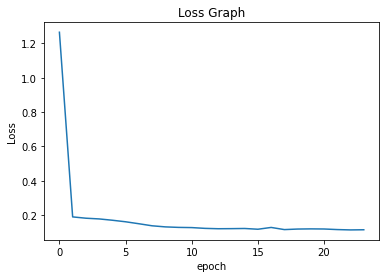

In [254]:
plt.plot(lossArr)
plt.title('Loss Graph')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

# Testing

In [255]:
def predict(seed, model):
    model.eval()
    res = model(seed.to(device))
    res = res.cpu().detach().numpy()
    return res

def test(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    testLoss, correct = 0,0
    with torch.no_grad():
        for batch, (x,y) in enumerate(dataloader):
            pred = model(x)
            testLoss += loss(pred, y).item()
    testLoss /= size
    print(f"Test Error: \n Avg loss: {testLoss:>8f} \n")

In [256]:
test(val_loader, lstm)

Test Error: 
 Avg loss: 0.000001 



In [262]:
testDataSet = calcVelocity(all_in_1)
valDataSet = calcVelocity(val_in_1)
# the first point of every path for generation
initTestP = []
initValP = []
for path in all_in_1:
    initTestP.append(path[0])
    
for path in val_in_1:
    initValP.append(path[0])

In [292]:
    

def processDataSet(data):
    processedData, convBackArr = shiftAndRotate(data)
    # now we have shifted & rotated data, then add velocity
    data_WV = addVelocity(processedData)
    return data_WV, convBackArr



# predict an entire path
def genPath(seed, model, pInit):
    vel_w_seed = seed
    path = [pInit]
#     for i in range(target_length - len(seed)):
    for i in range(59):
#         print (len(torch.Tensor(path_w_seed[i:i + 50])))
        vel_w_seed = np.concatenate((vel_w_seed, predict(torch.Tensor(vel_w_seed).unsqueeze(0), model)))
#         print(len(path_w_seed))
    for i in range(len(vel_w_seed)):
        path.append((np.array(path[i]) + np.array(vel_w_seed[i]))*1.0005)
    return path

In [293]:
import matplotlib.pyplot as plt
import math

# takes in a path and return x,y lists
def parsePath(path):
    tempX = []
    tempY = []
    for elem in path:
        tempX.append(elem[0])
        tempY.append(elem[1])
    return tempX, tempY

def showPath(x,y):
    plt.scatter(x[0:50],y[0:50], c='b')
    plt.scatter(x[50:],y[50:], c='r')

In [294]:
res = predict(torch.Tensor(valDataSet[200][0:60]).unsqueeze(0), lstm)
print(res)
print(valDataSet[200][60])

[[-0.05429824  0.02744416]]
[-0.06798349  0.0357124 ]


[  426.842508   -1543.81267252]


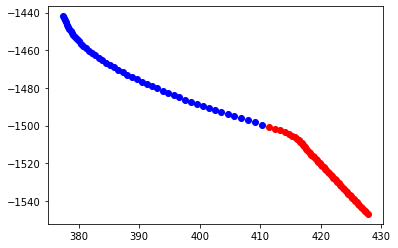

In [307]:
pathTest = genPath(valDataSet[900][0:50], lstm, initTestP[900])
print(pathTest[105])
xPath, yPath = parsePath(pathTest)
showPath(xPath, yPath)

[  318.25841397 -1464.04996853]


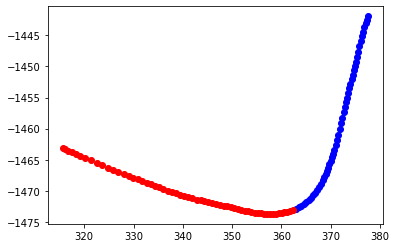

In [308]:
xPathT, yPathT = parsePath(all_in_1[900])
print(all_in_1[900][105])
showPath(xPathT, yPathT)